In [63]:
# Data manipulation
import pandas as pd
import numpy as np
from numpy.linalg import multi_dot, inv, det

# Visualization
import matplotlib.pyplot as plt
import seaborn as sn
plt.style.use('bmh')

from scipy.special import expit
from scipy.stats import linregress
from tabulate import tabulate

# Import Data Fetching libraries
import yfinance as yf

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

As an exercise lets check the data available to build a term structure spread for the **GC CME future contract**

In [2]:
# Array of ticker to dowload
tickers = ['GCN21.CMX', 'GCQ21.CMX', 'GCU21.CMX', 'GCV21.CMX', 'GCZ21.CMX']
# Fetch the data 
# df = yf.download(tickers, progress=False)['Adj Close']

# Storing the fetched data
# df.to_excel('data/GC.xlsx', 'GCN21')

In [105]:
# load file for Group A
df = pd.read_excel('data/GC.xlsx', index_col=0, parse_dates=True)

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1376 entries, 2015-12-30 to 2021-07-05
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GCN21.CMX  47 non-null     float64
 1   GCQ21.CMX  442 non-null    float64
 2   GCU21.CMX  5 non-null      float64
 3   GCV21.CMX  399 non-null    float64
 4   GCZ21.CMX  1376 non-null   float64
dtypes: float64(5)
memory usage: 64.5 KB


In [107]:
df[df['GCV21.CMX']>0].shape

(399, 5)

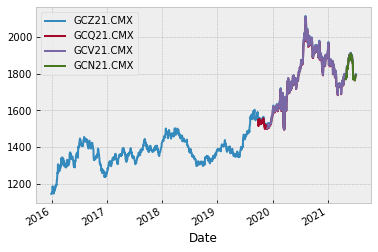

In [108]:
df.plot.line(y=['GCZ21.CMX','GCQ21.CMX','GCV21.CMX', 'GCN21.CMX']);

For the first 4 contracts available today, we only have 399 days of common data.

- Is 399 days enough?
- Should I use previous expired contracts? How?

It look like GC contracts are very correlated, we will check latter.

In [109]:
series = df[df['GCV21.CMX']>0][['GCQ21.CMX', 'GCV21.CMX', 'GCZ21.CMX']]

In [110]:
series.head()

,GCQ21.CMX,GCV21.CMX,GCZ21.CMX
Date,,,
2019-11-27,1498.500000,1502.400024,1506.599976
2019-12-02,1507.300049,1511.199951,1515.400024
2019-12-03,1522.800049,1526.699951,1530.900024
2019-12-04,1518.699951,1522.599976,1526.800049
2019-12-05,1521.699951,1525.599976,1529.599976


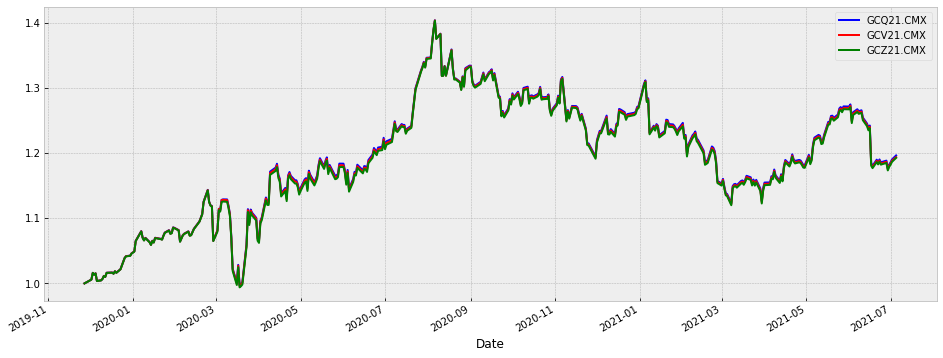

In [111]:
series_one = series/series.iloc[0]
series_one.plot(figsize=(16,6), color=('b', 'r', 'g'));

In [112]:
arr = np.array([[1,2,3],[2,3,4]])
arr.shape

(2, 3)

In [113]:
Y = series_one[['GCZ21.CMX']]#, 'GCV21.CMX']]
X = series_one[['GCQ21.CMX']]#, 'GCV21.CMX']]
m = Y.shape[0]
n = Y.shape[1]
l = X.shape[1]
print(m,n,l)

399 1 1


In [118]:
# Returns linear regression beta_hat estimate
# (X'X)−1X'𝑌
def estimate_beta(X, Y, c=False):
    # Copy series to workaround
    X_ = X.copy()
    Y_ = Y.copy()
    # If there is just 1 regressor add constant
#     if c or len(X_.columns)<2:
#         X_.insert(0,'c', 1)
    # Matrix operations
    op_1 = inv(X_.T@X_)
    op_2 = X_.T@Y
    beta_hat = op_1@op_2
    return (beta_hat.set_index(X_.columns), op_1, op_2)

In [119]:
beta_tuple = estimate_beta(X, Y)
beta_hat = beta_tuple[0]
beta_hat

,GCZ21.CMX
GCQ21.CMX,0.997299


In [122]:
# Returns linear regression residuals
# Y−XB_hat
def calculate_residuals(X, Y, beta_hat, c=True):
    # Copy series to workaround
    X_ = X.copy()
    Y_ = Y.copy()
    beta_hat_ = beta_hat.copy()
    # If there is just 1 regressor add constant
#     if c or len(X_.columns)<2:
#         X_.insert(0,'c', 1)
    # Matrix operations
    e_hat = Y - X_@beta_hat_
    return (e_hat)

In [123]:
e_hat = calculate_residuals(X, Y, beta_hat)
e_hat.head()

,GCZ21.CMX
Date,
2019-11-27,0.002701
2019-12-02,0.002685
2019-12-03,0.002657
2019-12-04,0.002665
2019-12-05,0.002527


In [15]:
# Returns linear regression residuals covarians matrix
# e_hatT e_hat/m
def calculate_residual_cov_matrix(e_hat, m):
    # Copy series to workaround
    e_hat_ = e_hat.copy()
    # Matrix operations
    sigma_hat = e_hat_.T@e_hat_/m
    return (sigma_hat)

In [16]:
sigma_hat = calculate_residual_cov_matrix(e_hat, m)
sigma_hat

,GCZ21.CMX
GCZ21.CMX,0.000002


In [17]:
# Returns linear regression covariance matrix of regression coefficients
# Σˆ⊗(𝑋𝑇𝑋)−1
def calculate_coeficient_cov_matrix(sigma_hat, op_1):
    # Copy series to workaround
    sigma_hat_ = sigma_hat.copy()
    op_1_ = op_1.copy()
    # Matrix operations
    cov_hat = np.kron(sigma_hat_, op_1_)
    return (cov_hat)

In [18]:
op_1 = beta_tuple[1]
cov_hat = calculate_coeficient_cov_matrix(sigma_hat, op_1)
cov_hat

array([[ 9.21204250e-07, -7.66769669e-07],
       [-7.66769669e-07,  6.41688306e-07]])

In [19]:
diag=np.diagonal(cov_hat)


In [20]:
m_ = m/(m-l)

In [21]:
var_2 = np.sqrt(m_ * diag)
var_2

array([0.000961  , 0.00080206])

In [22]:
beta_hat.iloc[1]/var_2[1]

GCZ21.CMX    1240.62183
Name: GCQ21.CMX, dtype: float64

--
**Trying multivariate autoregression**


In [23]:
# Array of ticker to dowload
ar_tickers = ['F', 'GM', 'SPY']
# Fetch the data 
# df = yf.download(ar_tickers, progress=False)['Adj Close']

# Storing the fetched data
# df.to_excel('data/ar.xlsx', 'ar')

In [94]:
# load file
ar = pd.read_excel('data/ar.xlsx', index_col=0, parse_dates=True)

In [95]:
ar = ar[(ar.index > '2010-11-17') & (ar.index <= '2016-10-1')]

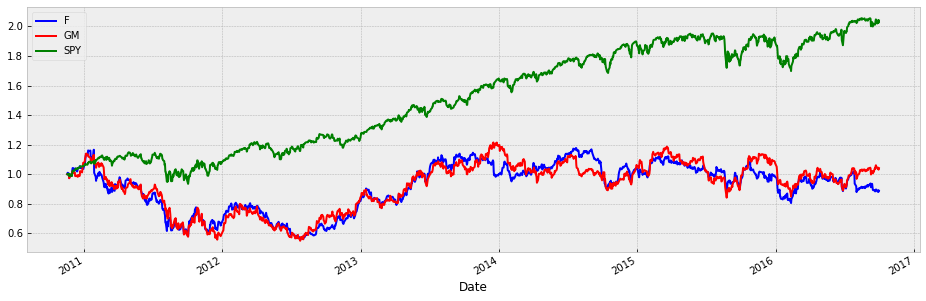

In [96]:
ar_1 = ar/ar.iloc[0]
ar_1.plot(figsize=(16,5), color=('b', 'r', 'g'));

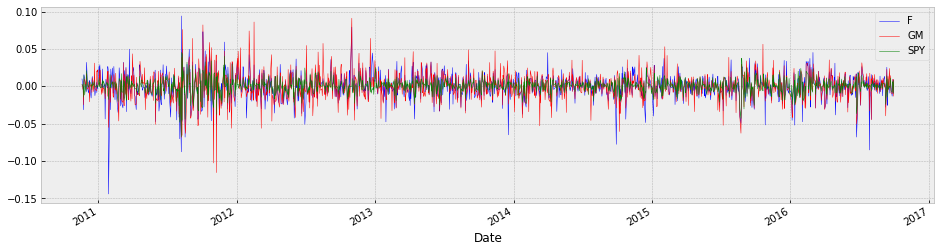

In [97]:
ar_returns = np.log(ar).diff().dropna()
ar_returns.plot(figsize=(16,4), color=('b', 'r', 'g'), linewidth=0.5);

In [98]:
for key in ar_returns.columns:
    ar_returns[key+'_t-1'] = ar_returns[key].shift(1)
ar_returns.dropna(inplace=True)
ar_returns.head()

,F,GM,SPY,F_t-1,GM_t-1,SPY_t-1
Date,,,,,,
2010-11-22,-0.004926,-0.005267,-0.000832,0.009877,0.002045,0.002748
2010-11-23,-0.031351,-0.024656,-0.014583,-0.004926,-0.005267,-0.000832
2010-11-24,0.015798,0.006893,0.014666,-0.031351,-0.024656,-0.014583
2010-11-26,0.009360,0.009513,-0.011716,0.015798,0.006893,0.014666
2010-11-29,-0.002488,0.000000,0.003026,0.009360,0.009513,-0.011716


In [99]:
Y = ar_returns.iloc[:,0:3]
Y.head()

,F,GM,SPY
Date,,,
2010-11-22,-0.004926,-0.005267,-0.000832
2010-11-23,-0.031351,-0.024656,-0.014583
2010-11-24,0.015798,0.006893,0.014666
2010-11-26,0.009360,0.009513,-0.011716
2010-11-29,-0.002488,0.000000,0.003026


In [100]:
X = ar_returns.iloc[:,3:]
X.head()

,F_t-1,GM_t-1,SPY_t-1
Date,,,
2010-11-22,0.009877,0.002045,0.002748
2010-11-23,-0.004926,-0.005267,-0.000832
2010-11-24,-0.031351,-0.024656,-0.014583
2010-11-26,0.015798,0.006893,0.014666
2010-11-29,0.009360,0.009513,-0.011716


In [101]:
m = Y.shape[0]
n = Y.shape[1]
l = X.shape[1]
print(m,n,l)

1475 3 3


In [32]:
beta_tuple = estimate_beta(X, Y)
beta_hat = beta_tuple[0]
beta_hat

,F,GM,SPY
c,-0.000037,0.000030,0.000508
F_t-1,0.101882,0.058611,0.005369
GM_t-1,-0.005225,-0.018571,0.004112
SPY_t-1,-0.084568,0.001902,-0.055843


In [33]:
e_hat = calculate_residuals(X, Y, beta_hat)
e_hat.head()

,F,GM,SPY
Date,,,
2010-11-22,-0.005652,-0.005844,-0.001248
2010-11-23,-0.030909,-0.024493,-0.015090
2010-11-24,0.017668,0.008271,0.013613
2010-11-26,0.009065,0.008657,-0.011518
2010-11-29,-0.004345,-0.000380,0.001774


In [34]:
sigma_hat = calculate_residual_cov_matrix(e_hat, m)
sigma_hat

,F,GM,SPY
F,0.000293,0.000226,0.000114
GM,0.000226,0.000338,0.000115
SPY,0.000114,0.000115,0.000091


In [35]:
index = X.columns.insert(0, 'c')
index

Index(['c', 'F_t-1', 'GM_t-1', 'SPY_t-1'], dtype='object')

In [36]:
op_1 = pd.DataFrame(beta_tuple[1], columns=index).set_index(index)
op_1

,c,F_t-1,GM_t-1,SPY_t-1
c,0.000682,0.002521,0.000938,-0.007887
F_t-1,0.002521,5.831193,-2.514913,-4.121819
GM_t-1,0.000938,-2.514913,4.570292,-2.610528
SPY_t-1,-0.007887,-4.121819,-2.610528,15.873421


In [37]:
cov_hat = calculate_coeficient_cov_matrix(sigma_hat, op_1)
np.diag(cov_hat)

array([1.99967371e-07, 1.70991719e-03, 1.34017532e-03, 4.65466226e-03,
       2.30778731e-07, 1.97338454e-03, 1.54667213e-03, 5.37186164e-03,
       6.20718459e-08, 5.30775174e-04, 4.16003647e-04, 1.44485311e-03])

In [81]:
# Returns linear regression Standard error of regression coefficient:
# (Var(𝛽ˆ𝑘𝑗))1/2 = (𝑚/𝑚−ℓdiag(𝐶𝑜𝑉ˆ)𝑘𝑗)1/2
def calculate_coeficient_SD(cov_hat, m, n, l):
    # Copy series to workaround
    cov_hat_ = cov_hat.copy()
    diag_cov_hat_ = np.diag(cov_hat_)
    # Matrix operations
    beta_var = np.sqrt((m / (m-l)) * diag_cov_hat_).reshape(n,l+1).T
    return (beta_var)

In [82]:
beta_var = calculate_coeficient_SD(cov_hat, m, n, l)
beta_var = pd.DataFrame(beta_var, columns=Y.columns).set_index(beta_hat.index)
beta_var

,F,GM,SPY
c,0.000448,0.000481,0.000249
F_t-1,0.041393,0.044468,0.023062
GM_t-1,0.036646,0.039368,0.020417
SPY_t-1,0.068295,0.073368,0.038050


In [83]:
# Returns linear regression t-statistic:
# 𝛽ˆ𝑘𝑗/(Var(𝛽ˆ𝑘𝑗))1/2
def calculate_t_stat(beta_hat, beta_var):
    # Copy series to workaround
    beta_hat_ = beta_hat.copy()
    beta_var_ = beta_var.copy()
    # Matrix operations
    var_beta = beta_hat_ / beta_var_
    return (var_beta)

In [84]:
t_stat = calculate_t_stat(beta_hat, beta_var)
t_stat

,F,GM,SPY
c,-0.083591,0.062185,2.038190
F_t-1,2.461309,1.318058,0.232798
GM_t-1,-0.142579,-0.471718,0.201414
SPY_t-1,-1.238281,0.025920,-1.467631


In [85]:
# Returns linear regression AIC:
# log∣Σˆ∣+2ℓ𝑛/𝑚
def calculate_aic(sigma_hat, m, n, l):
    # Copy series to workaround
    sigma_hat_ = sigma_hat.copy()
    # Matrix operations
    aic = np.log(det(sigma_hat_)) + (2 * l * n / m)
    return (aic)

In [86]:
aic = calculate_aic(sigma_hat, m, n, l)
aic

-26.91283502814211

In [87]:
# Returns linear regression BIC:
# log∣∣Σˆ∣∣+log(𝑚)ℓ𝑛/𝑚
def calculate_bic(sigma_hat, m, n, l):
    # Copy series to workaround
    sigma_hat_ = sigma_hat.copy()
    # Matrix operations
    bic = np.log(det(sigma_hat_)) + (np.log(m) * l * n / m)
    return (bic)

In [88]:
bic = calculate_bic(sigma_hat, m, n, l)
bic

-26.880517930230944